# Challenge 3: Artifical Neural Networks

<a target="_blank" href="https://colab.research.google.com/github/LucaPennella/Intro_to_ML_23-24/blob/main/challenges/challenge-three.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


Using Fully Connected Neural Networks and Convolutional Neural Networks, perform the following tasks on [KMNIST](https://pytorch.org/vision/stable/generated/torchvision.datasets.KMNIST.html#torchvision.datasets.KMNIST).
1. Data exploration.
    * Provide a grid plot of the first 10/12 examples with associated labels
    * Split using the provided pytorch objects into train/validation/test sets
2. For each architecture, tune the number of the hidden layers ($\le 3$), the optimizer, and some hyperparameters of your choice. How many tries to do is up to your discretion. Discuss the choice you made in the report.
3. Summarise your results in a table and comment on them in the report. 
4. For a model (not necessarily the best performing one), plot training loss vs testing loss and training accuracy vs testing accuracy, and comment on what you see.
    * Beyond accuracy provide the confusion matrix for the model outputs. Discuss differences between train/validation/test sets. Is accuracy a good metric in this case why or why not?

# Data Integration and Exploration

In [1]:
import torch
import torch.nn as nn # basic building blocks for graphs
import torch.nn.functional as F # dropout, loss, activation functions, and more
import torchvision # popular datasets, model architectures, and image transformations for computer vision
import torchvision.transforms as transforms # common image transformations

import matplotlib.pyplot as plt
import numpy as np
from time import time

from tqdm import tqdm


In [2]:
BS = 128 # Define batch size
data_transforms = transforms.ToTensor()

In [3]:
data = torchvision.datasets.KMNIST(
    root='./data', train=True, download=True, transform=data_transforms
)
# I won't define the train_loader as I will do the hold-out split later for model validation

test = torchvision.datasets.KMNIST(
    root='./data', train=False, download=True, transform=data_transforms
)
test_loader = torch.utils.data.DataLoader(test)


In [4]:
# Avoids jupyter kernel crashes
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

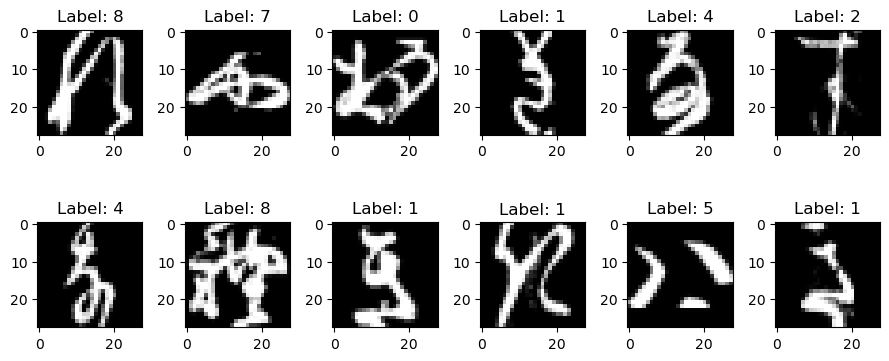

In [5]:
# Visualize first 12 samples of data
num_row = 2
num_col = 6

fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col, 2*num_row))
for i in range(num_row*num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(data.data[i], cmap='gray')
    ax.set_title('Label: {}'.format(data.targets[i]))
plt.tight_layout()
plt.show()

In [6]:
data.data[0].shape 
# Each image is 28x28 with 1 channel only (greyscale), so a batch is BS X 28 X 28

torch.Size([28, 28])

In [7]:
# Use hold-out method on train dataset for train-validation splitting. Proportion is 70-30
from torch.utils.data.sampler import SubsetRandomSampler

N = len(data)
idx = list(range(N))

train_size = int(np.floor(N * 0.7))

shuffle_dataset = True
if shuffle_dataset:
    np.random.seed(42)
    np.random.shuffle(idx)

train_idx, val_idx = idx[:train_size], idx[train_size:]

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

train_loader = torch.utils.data.DataLoader(data, batch_size = BS, sampler=train_idx)
val_loader = torch.utils.data.DataLoader(data, batch_size = BS, sampler=val_idx)


# Modelling

## CNNs

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolution Layer 1: BS x 28 x 28 -> BS X 28 x 28 x 3
        self.conv_layer_1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, stride=1, padding=0, dilation=1, groups=1)

        # Pooling: BS X 26 x 26 x 3 -> BS x 13 x 13 x 3
        self.pool_1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Layer 1: BS x 13 x 13 x 3 -> BS x 255
        self.hidden_1 = nn.Linear(13*13*3, 255)

        # Layer 2: BS x 255 -> 10
        self.hidden_2 = nn.Linear(255, 10)

    def forward(self, x):
        x = self.conv_layer_1(x)
        x = self.pool_1(x)
        x = F.relu(x)
        x = x.flatten(start_dim=1)
        x = self.hidden_1(x)
        x = F.relu(x)
        x = self.hidden_2(x)
        x = F.relu(x)

        return x 

## FCNNs

In [96]:
class FCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(28*28, 1024)
        self.layer_2 = nn.Linear(1024, 2048)
        self.layer_3 = nn.Linear(2048, 512)
        self.out = nn.Linear(512, 10)

    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = self.layer_1(x)
        x = F.relu(x)
        x = self.layer_2(x)
        x = F.tanh(x)
        x = self.layer_3(x)
        x = F.relu(x)
        x = self.out(x)

        return x

## Define Auxiliary Functions (define the training logic, testing logic, and get confusion matrix)

In [31]:
# functions

def get_accuracy(logit, target):
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects / target.size(0)
    return accuracy.item()


def compute_weight_norm(model):
    norm = 0.0
    for name, param in model.named_parameters():
      if "weight" in name:
        norm += torch.norm(param.data, p= 2)
    return norm.cpu().item()


def train_model(model, num_epochs, trainloader, criterion, optimizer):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = model.to(device)

    losses = []
    print("TRAINING MODEL!")

    for epoch in (range(num_epochs)):
        train_running_loss = 0.0
        train_acc = 0.0

        # Set the model to training mode
        model = model.train()
        start = time()
        ## training step
        for i, (images, labels) in tqdm(enumerate(trainloader)):
            
            images = images.to(device)
            labels = labels.to(device)

            ## forward + backprop + loss
            logits = model(images)
            loss = criterion(logits, labels)

            # Reset the gradients to zero
            optimizer.zero_grad()

            loss.backward()

            ## update model params
            optimizer.step()

            train_running_loss += loss.item()
            train_acc += get_accuracy(logits, labels)
        
            
        losses.append(train_running_loss / i)
        model.eval()

        print(f"Epoch: {epoch+1} | Loss: {train_running_loss / i:.4f} | Train Accuracy: {train_acc/i:.4f} | Time: {time()-start:.2f}") 
    
    return losses

In [ ]:
import sklearn.metrics 

def val_model(model, valloader, data):
    # Obs. data parameter is just to get the number of classes

    model.eval() # Sets to evaluation mode: i'm basically just freezing the gradients

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Initialize empty confusion matrix
    CLASSES = data.targets.unique()

    CLASSES = CLASSES.to(device)
    
    N_CLASSES = CLASSES.shape[0]

    my_confusion_matrix = torch.zeros((N_CLASSES, N_CLASSES))

    print("EVALUATING MODEL")
    for images, labels in tqdm(valloader):
        images = images.to(device)
        labels = labels.to(device)
        
        y_hat = model(images)
        y_pred = torch.argmax(y_hat, dim=1)

        # Copy to CPU memory since i'm going to use sklearn (idk)
        labels_ = labels.cpu()
        y_pred_ = y_pred.cpu()
        CLASSES_= CLASSES.cpu()

        cm_i = sklearn.metrics.confusion_matrix(labels_, y_pred_, labels=CLASSES_)

        my_confusion_matrix += cm_i
    
    return my_confusion_matrix

# Model Training

NOTE: I managed to train a CNN that achieves 99% accuracy on train set, however I lost their loss vector by accidentally overwriting it (but I still managed to keep their weights on a separate file)

In [291]:
my_cnn = CNN()

CE = nn.CrossEntropyLoss()
cnn_optimizer1 = torch.optim.Adam(my_cnn.parameters())

cnn_loss1 = train_model(my_cnn, 50, train_loader, CE, cnn_optimizer1)

TRAINING MODEL!


329it [00:06, 54.72it/s]


Epoch: 1 | Loss: 0.7427 | Train Accuracy: 79.2635 | Time: 6.02


329it [00:05, 55.14it/s]


Epoch: 2 | Loss: 0.3752 | Train Accuracy: 88.5790 | Time: 5.97


329it [00:05, 56.03it/s]


Epoch: 3 | Loss: 0.2779 | Train Accuracy: 91.4825 | Time: 5.88


329it [00:06, 54.16it/s]


Epoch: 4 | Loss: 0.2235 | Train Accuracy: 93.1498 | Time: 6.08


329it [00:06, 50.21it/s]


Epoch: 5 | Loss: 0.1307 | Train Accuracy: 96.6297 | Time: 6.56


329it [00:07, 44.89it/s]


Epoch: 6 | Loss: 0.0991 | Train Accuracy: 97.5395 | Time: 7.34


329it [00:11, 28.26it/s]


Epoch: 7 | Loss: 0.0785 | Train Accuracy: 98.1779 | Time: 11.65


329it [00:06, 54.51it/s]


Epoch: 8 | Loss: 0.0632 | Train Accuracy: 98.6876 | Time: 6.05


329it [00:06, 54.70it/s]


Epoch: 9 | Loss: 0.0510 | Train Accuracy: 99.0735 | Time: 6.02


329it [00:06, 54.70it/s]


Epoch: 10 | Loss: 0.0417 | Train Accuracy: 99.3093 | Time: 6.02


329it [00:05, 55.04it/s]


Epoch: 11 | Loss: 0.0336 | Train Accuracy: 99.5546 | Time: 5.98


329it [00:05, 55.17it/s]


Epoch: 12 | Loss: 0.0261 | Train Accuracy: 99.7547 | Time: 5.97


329it [00:05, 56.47it/s]


Epoch: 13 | Loss: 0.0216 | Train Accuracy: 99.8547 | Time: 5.83


329it [00:05, 56.65it/s]


Epoch: 14 | Loss: 0.0189 | Train Accuracy: 99.8952 | Time: 5.81


329it [00:05, 58.26it/s]


Epoch: 15 | Loss: 0.0164 | Train Accuracy: 99.9405 | Time: 5.65


329it [00:05, 56.03it/s]


Epoch: 16 | Loss: 0.0175 | Train Accuracy: 99.8333 | Time: 5.88


329it [00:05, 55.84it/s]


Epoch: 17 | Loss: 0.0161 | Train Accuracy: 99.8619 | Time: 5.89


329it [00:05, 56.58it/s]


Epoch: 18 | Loss: 0.0132 | Train Accuracy: 99.9809 | Time: 5.82


329it [00:05, 55.38it/s]


Epoch: 19 | Loss: 0.0101 | Train Accuracy: 100.0524 | Time: 5.94


329it [00:05, 56.77it/s]


Epoch: 20 | Loss: 0.0109 | Train Accuracy: 99.9905 | Time: 5.80


329it [00:05, 55.78it/s]


Epoch: 21 | Loss: 0.0093 | Train Accuracy: 100.0524 | Time: 5.90


329it [00:05, 56.09it/s]


Epoch: 22 | Loss: 0.0074 | Train Accuracy: 100.1072 | Time: 5.87


329it [00:05, 56.48it/s]


Epoch: 23 | Loss: 0.0070 | Train Accuracy: 100.1072 | Time: 5.83


329it [00:05, 55.89it/s]


Epoch: 24 | Loss: 0.0100 | Train Accuracy: 100.0119 | Time: 5.89


329it [00:05, 55.06it/s]


Epoch: 25 | Loss: 0.0065 | Train Accuracy: 100.1215 | Time: 5.98


329it [00:05, 56.26it/s]


Epoch: 26 | Loss: 0.0050 | Train Accuracy: 100.1643 | Time: 5.85


329it [00:05, 58.82it/s]


Epoch: 27 | Loss: 0.0059 | Train Accuracy: 100.1286 | Time: 5.60


329it [00:05, 58.11it/s]


Epoch: 28 | Loss: 0.0166 | Train Accuracy: 99.7475 | Time: 5.67


329it [00:05, 57.07it/s]


Epoch: 29 | Loss: 0.0075 | Train Accuracy: 100.0667 | Time: 5.77


329it [00:05, 57.21it/s]


Epoch: 30 | Loss: 0.0041 | Train Accuracy: 100.1739 | Time: 5.76


329it [00:05, 57.79it/s]


Epoch: 31 | Loss: 0.0029 | Train Accuracy: 100.2167 | Time: 5.69


329it [00:05, 56.90it/s]


Epoch: 32 | Loss: 0.0025 | Train Accuracy: 100.2215 | Time: 5.79


329it [00:05, 56.76it/s]


Epoch: 33 | Loss: 0.0029 | Train Accuracy: 100.2096 | Time: 5.80


329it [00:05, 56.58it/s]


Epoch: 34 | Loss: 0.0164 | Train Accuracy: 99.7404 | Time: 5.82


329it [00:05, 56.39it/s]


Epoch: 35 | Loss: 0.0087 | Train Accuracy: 100.0238 | Time: 5.84


329it [00:05, 58.32it/s]


Epoch: 36 | Loss: 0.0036 | Train Accuracy: 100.2025 | Time: 5.64


329it [00:05, 57.13it/s]


Epoch: 37 | Loss: 0.0025 | Train Accuracy: 100.2215 | Time: 5.76


329it [00:05, 57.80it/s]


Epoch: 38 | Loss: 0.0023 | Train Accuracy: 100.2239 | Time: 5.70


329it [00:05, 57.59it/s]


Epoch: 39 | Loss: 0.0023 | Train Accuracy: 100.2215 | Time: 5.72


329it [00:05, 55.87it/s]


Epoch: 40 | Loss: 0.0023 | Train Accuracy: 100.2239 | Time: 5.89


329it [00:05, 56.56it/s]


Epoch: 41 | Loss: 0.0022 | Train Accuracy: 100.2239 | Time: 5.82


329it [00:05, 55.15it/s]


Epoch: 42 | Loss: 0.0022 | Train Accuracy: 100.2215 | Time: 5.97


329it [00:05, 55.39it/s]


Epoch: 43 | Loss: 0.0022 | Train Accuracy: 100.2239 | Time: 5.94


329it [00:05, 56.54it/s]


Epoch: 44 | Loss: 0.0022 | Train Accuracy: 100.2239 | Time: 5.82


329it [00:05, 55.87it/s]


Epoch: 45 | Loss: 0.0022 | Train Accuracy: 100.2239 | Time: 5.89


329it [00:05, 55.22it/s]


Epoch: 46 | Loss: 0.0022 | Train Accuracy: 100.2215 | Time: 5.96


329it [00:06, 54.57it/s]


Epoch: 47 | Loss: 0.0179 | Train Accuracy: 99.8118 | Time: 6.03


329it [00:05, 56.28it/s]


Epoch: 48 | Loss: 0.0180 | Train Accuracy: 99.7642 | Time: 5.85


329it [00:05, 58.42it/s]


Epoch: 49 | Loss: 0.0045 | Train Accuracy: 100.1643 | Time: 5.64


329it [00:05, 55.38it/s]

Epoch: 50 | Loss: 0.0026 | Train Accuracy: 100.2215 | Time: 5.94


how... sometimes it reaches 80, sometimes 60, sometimes its crap... the function is clearly non-convex

In [306]:
torch.save(my_cnn.state_dict(), "./weights/cnn_super") # SAVE THE WEIGHTS FOR PRESERVABILITY!!!!

In [307]:
my_cnn_again = CNN()

CE = nn.CrossEntropyLoss()
cnn_optimizer1 = torch.optim.Adam(my_cnn_again.parameters())

cnn_loss2 = train_model(my_cnn_again, 50, train_loader, CE, cnn_optimizer1)

TRAINING MODEL!


329it [00:06, 53.04it/s]


Epoch: 1 | Loss: 1.2270 | Train Accuracy: 57.7315 | Time: 6.21


329it [00:06, 54.46it/s]


Epoch: 2 | Loss: 1.0294 | Train Accuracy: 61.6068 | Time: 6.05


329it [00:06, 53.97it/s]


Epoch: 3 | Loss: 0.9614 | Train Accuracy: 63.0478 | Time: 6.10


329it [00:06, 53.08it/s]


Epoch: 4 | Loss: 0.9174 | Train Accuracy: 63.9196 | Time: 6.20


329it [00:05, 57.21it/s]


Epoch: 5 | Loss: 0.8889 | Train Accuracy: 64.4412 | Time: 5.76


329it [00:05, 56.81it/s]


Epoch: 6 | Loss: 0.8654 | Train Accuracy: 65.0367 | Time: 5.79


329it [00:05, 56.28it/s]


Epoch: 7 | Loss: 0.8471 | Train Accuracy: 65.4702 | Time: 5.85


329it [00:05, 55.77it/s]


Epoch: 8 | Loss: 0.8328 | Train Accuracy: 65.7631 | Time: 5.90


329it [00:05, 56.20it/s]


Epoch: 9 | Loss: 0.8219 | Train Accuracy: 65.9537 | Time: 5.86


329it [00:05, 57.26it/s]


Epoch: 10 | Loss: 0.8132 | Train Accuracy: 66.1752 | Time: 5.75


329it [00:05, 58.53it/s]


Epoch: 11 | Loss: 0.7587 | Train Accuracy: 68.6309 | Time: 5.62


329it [00:05, 58.34it/s]


Epoch: 12 | Loss: 0.5723 | Train Accuracy: 77.9321 | Time: 5.64


329it [00:05, 57.51it/s]


Epoch: 13 | Loss: 0.5355 | Train Accuracy: 78.6966 | Time: 5.73


329it [00:05, 57.21it/s]


Epoch: 14 | Loss: 0.5228 | Train Accuracy: 78.9110 | Time: 5.75


329it [00:05, 56.90it/s]


Epoch: 15 | Loss: 0.5108 | Train Accuracy: 79.1921 | Time: 5.79


329it [00:05, 57.52it/s]


Epoch: 16 | Loss: 0.5013 | Train Accuracy: 79.3564 | Time: 5.72


329it [00:05, 56.67it/s]


Epoch: 17 | Loss: 0.4944 | Train Accuracy: 79.4731 | Time: 5.81


329it [00:05, 55.81it/s]


Epoch: 18 | Loss: 0.4912 | Train Accuracy: 79.5112 | Time: 5.90


329it [00:05, 57.40it/s]


Epoch: 19 | Loss: 0.4893 | Train Accuracy: 79.4922 | Time: 5.74


329it [00:05, 56.83it/s]


Epoch: 20 | Loss: 0.4901 | Train Accuracy: 79.4612 | Time: 5.79


329it [00:05, 58.07it/s]


Epoch: 21 | Loss: 0.4856 | Train Accuracy: 79.5636 | Time: 5.67


329it [00:05, 57.02it/s]


Epoch: 22 | Loss: 0.4852 | Train Accuracy: 79.5494 | Time: 5.77


329it [00:05, 57.06it/s]


Epoch: 23 | Loss: 0.4848 | Train Accuracy: 79.5470 | Time: 5.77


329it [00:05, 56.34it/s]


Epoch: 24 | Loss: 0.4841 | Train Accuracy: 79.5613 | Time: 5.84


329it [00:05, 55.69it/s]


Epoch: 25 | Loss: 0.4828 | Train Accuracy: 79.5827 | Time: 5.91


329it [00:05, 56.04it/s]


Epoch: 26 | Loss: 0.4831 | Train Accuracy: 79.5946 | Time: 5.87


329it [00:05, 55.36it/s]


Epoch: 27 | Loss: 0.4837 | Train Accuracy: 79.5636 | Time: 5.95


329it [00:05, 56.17it/s]


Epoch: 28 | Loss: 0.4807 | Train Accuracy: 79.6351 | Time: 5.86


329it [00:05, 56.29it/s]


Epoch: 29 | Loss: 0.4811 | Train Accuracy: 79.6375 | Time: 5.85


329it [00:05, 58.23it/s]


Epoch: 30 | Loss: 0.4783 | Train Accuracy: 79.6732 | Time: 5.65


329it [00:05, 56.88it/s]


Epoch: 31 | Loss: 0.4800 | Train Accuracy: 79.6351 | Time: 5.79


329it [00:05, 56.28it/s]


Epoch: 32 | Loss: 0.4810 | Train Accuracy: 79.6232 | Time: 5.85


329it [00:05, 56.63it/s]


Epoch: 33 | Loss: 0.4802 | Train Accuracy: 79.6232 | Time: 5.81


329it [00:05, 57.70it/s]


Epoch: 34 | Loss: 0.4780 | Train Accuracy: 79.6732 | Time: 5.71


329it [00:05, 57.00it/s]


Epoch: 35 | Loss: 0.4794 | Train Accuracy: 79.6470 | Time: 5.77


329it [00:05, 56.20it/s]


Epoch: 36 | Loss: 0.4769 | Train Accuracy: 79.7208 | Time: 5.86


329it [00:05, 56.62it/s]


Epoch: 37 | Loss: 0.4763 | Train Accuracy: 79.7280 | Time: 5.81


329it [00:05, 57.31it/s]


Epoch: 38 | Loss: 0.4751 | Train Accuracy: 79.7447 | Time: 5.74


329it [00:05, 56.19it/s]


Epoch: 39 | Loss: 0.4746 | Train Accuracy: 79.7566 | Time: 5.86


329it [00:05, 56.60it/s]


Epoch: 40 | Loss: 0.4769 | Train Accuracy: 79.7161 | Time: 5.81


329it [00:05, 55.12it/s]


Epoch: 41 | Loss: 0.4821 | Train Accuracy: 79.5827 | Time: 5.97


329it [00:06, 53.25it/s]


Epoch: 42 | Loss: 0.4806 | Train Accuracy: 79.6327 | Time: 6.18


329it [00:06, 53.04it/s]


Epoch: 43 | Loss: 0.4765 | Train Accuracy: 79.7018 | Time: 6.21


329it [00:06, 53.68it/s]


Epoch: 44 | Loss: 0.4746 | Train Accuracy: 79.7566 | Time: 6.13


329it [00:06, 54.21it/s]


Epoch: 45 | Loss: 0.4754 | Train Accuracy: 79.7328 | Time: 6.07


329it [00:05, 55.00it/s]


Epoch: 46 | Loss: 0.4751 | Train Accuracy: 79.7542 | Time: 5.98


329it [00:05, 56.43it/s]


Epoch: 47 | Loss: 0.4740 | Train Accuracy: 79.7756 | Time: 5.83


329it [00:05, 55.71it/s]


Epoch: 48 | Loss: 0.4791 | Train Accuracy: 79.6494 | Time: 5.91


329it [00:06, 53.81it/s]


Epoch: 49 | Loss: 0.4793 | Train Accuracy: 79.6565 | Time: 6.12


329it [00:06, 54.64it/s]


Epoch: 50 | Loss: 0.4760 | Train Accuracy: 79.7351 | Time: 6.02


In [308]:
torch.save(my_cnn_again.state_dict(), "./weights/cnn_bad_minima") # SAVE THE WEIGHTS FOR PRESERVABILITY!!!!

In [321]:
np.savetxt('./losses/cnn2.csv', cnn_loss2, delimiter=',', fmt='%.16f')
np.savetxt('./losses/cnn1.csv', cnn_loss1, delimiter=',', fmt='%.16f')


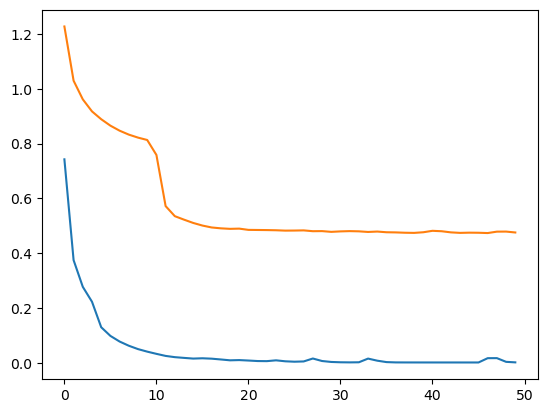

In [323]:
plt.plot(cnn_loss1)
plt.plot(cnn_loss2)

In [ ]:
# Notice how the results have drastically changed, meaning that the problem is likely non-convex and the initialization may be a crucial step.
cnn_normal = CNN()
cnn_zeros = CNN()
cnn_dirac = CNN()
cnn_xavier = CNN()

torch.nn.init.normal_(cnn_normal.conv_layer_1.weight)
torch.nn.init.zeros_(cnn_zeros.conv_layer_1.weight)
torch.nn.init.dirac_(cnn_dirac.conv_layer_1.weight)
torch.nn.init.xavier_uniform_(cnn_xavier.conv_layer_1.weight)


Parameter containing:
tensor([[[[-0.1255,  0.2249,  0.3344],
          [ 0.3397,  0.2720, -0.2263],
          [ 0.4073, -0.3830,  0.0897]]],


        [[[-0.1859,  0.1628,  0.2028],
          [ 0.0628, -0.0516, -0.1827],
          [-0.3572,  0.3852, -0.2962]]],


        [[[-0.3405, -0.2707, -0.3200],
          [ 0.3651, -0.0326,  0.2960],
          [-0.3475, -0.3397,  0.0440]]]], requires_grad=True)

In [93]:
models = [cnn_normal, cnn_zeros, cnn_dirac, cnn_xavier]

renamer = {
    cnn_normal: 'cnn normal',
    cnn_zeros: 'cnn zeros',
    cnn_dirac: 'cnn dirac',
    cnn_xavier: 'xavier'
}

losses = {}

In [ ]:
for model in models:  
    print(renamer[model])
    losses[renamer[model]] = train_model(model, 50, train_loader, CE, torch.optim.Adam(model.parameters()))

    print("="*80)
    pass


cnn normal
TRAINING MODEL!


329it [00:05, 55.39it/s]


Epoch: 1 | Loss: 1.6256 | Train Accuracy: 34.7752 | Time: 5.95


329it [00:05, 55.88it/s]


Epoch: 2 | Loss: 1.5349 | Train Accuracy: 36.0876 | Time: 5.89


329it [00:05, 56.52it/s]


Epoch: 3 | Loss: 1.5117 | Train Accuracy: 36.3781 | Time: 5.82


329it [00:05, 56.91it/s]


Epoch: 4 | Loss: 1.4967 | Train Accuracy: 36.6354 | Time: 5.79


329it [00:05, 55.57it/s]


Epoch: 5 | Loss: 1.4876 | Train Accuracy: 36.7902 | Time: 5.92


329it [00:11, 27.62it/s]


Epoch: 6 | Loss: 1.1130 | Train Accuracy: 55.1258 | Time: 11.92


329it [00:18, 17.64it/s]


Epoch: 7 | Loss: 0.8250 | Train Accuracy: 67.1804 | Time: 18.66


329it [00:17, 18.78it/s]


Epoch: 8 | Loss: 0.7698 | Train Accuracy: 68.6333 | Time: 17.53


329it [00:05, 56.03it/s]


Epoch: 9 | Loss: 0.7486 | Train Accuracy: 69.0620 | Time: 5.88


329it [00:05, 56.81it/s]


Epoch: 10 | Loss: 0.7354 | Train Accuracy: 69.3193 | Time: 5.79
cnn zeros
TRAINING MODEL!


329it [00:05, 55.56it/s]


Epoch: 1 | Loss: 2.0287 | Train Accuracy: 22.9778 | Time: 5.93


329it [00:05, 55.94it/s]


Epoch: 2 | Loss: 1.8262 | Train Accuracy: 26.9055 | Time: 5.88


329it [00:05, 57.42it/s]


Epoch: 3 | Loss: 1.7960 | Train Accuracy: 27.2437 | Time: 5.73


329it [00:05, 58.33it/s]


Epoch: 4 | Loss: 1.6608 | Train Accuracy: 34.8252 | Time: 5.64


329it [00:05, 61.78it/s]


Epoch: 5 | Loss: 1.5851 | Train Accuracy: 36.6259 | Time: 5.33


329it [00:05, 58.41it/s]


Epoch: 6 | Loss: 1.5571 | Train Accuracy: 37.0641 | Time: 5.64


329it [00:12, 26.26it/s]


Epoch: 7 | Loss: 1.5386 | Train Accuracy: 37.3047 | Time: 12.53


329it [00:05, 55.16it/s]


Epoch: 8 | Loss: 1.5252 | Train Accuracy: 37.4809 | Time: 5.97


329it [00:05, 55.36it/s]


Epoch: 9 | Loss: 1.5148 | Train Accuracy: 37.6429 | Time: 5.95


329it [00:13, 24.64it/s]


Epoch: 10 | Loss: 1.5061 | Train Accuracy: 37.7572 | Time: 13.36
cnn dirac
TRAINING MODEL!


329it [00:06, 51.81it/s]


Epoch: 1 | Loss: 1.2722 | Train Accuracy: 56.9336 | Time: 6.35


329it [00:06, 53.73it/s]


Epoch: 2 | Loss: 1.0586 | Train Accuracy: 60.4540 | Time: 6.13


329it [00:06, 53.44it/s]


Epoch: 3 | Loss: 0.9903 | Train Accuracy: 61.8617 | Time: 6.16


329it [00:06, 54.80it/s]


Epoch: 4 | Loss: 0.9408 | Train Accuracy: 63.1240 | Time: 6.01


329it [00:05, 55.69it/s]


Epoch: 5 | Loss: 0.8668 | Train Accuracy: 65.9513 | Time: 5.91


329it [00:05, 55.41it/s]


Epoch: 6 | Loss: 0.8280 | Train Accuracy: 67.1994 | Time: 5.94


329it [00:05, 55.62it/s]


Epoch: 7 | Loss: 0.8067 | Train Accuracy: 67.7687 | Time: 5.92


329it [00:05, 56.41it/s]


Epoch: 8 | Loss: 0.7915 | Train Accuracy: 68.0831 | Time: 5.84


329it [00:06, 54.12it/s]


Epoch: 9 | Loss: 0.7801 | Train Accuracy: 68.2927 | Time: 6.08


329it [00:05, 57.06it/s]


Epoch: 10 | Loss: 0.7699 | Train Accuracy: 68.4785 | Time: 5.77
xavier
TRAINING MODEL!


329it [00:05, 57.45it/s]


Epoch: 1 | Loss: 1.2699 | Train Accuracy: 56.9908 | Time: 5.73


329it [00:05, 56.84it/s]


Epoch: 2 | Loss: 1.0268 | Train Accuracy: 61.6949 | Time: 5.79


329it [00:05, 55.36it/s]


Epoch: 3 | Loss: 0.9518 | Train Accuracy: 63.3003 | Time: 5.95


329it [00:05, 58.64it/s]


Epoch: 4 | Loss: 0.9064 | Train Accuracy: 64.3459 | Time: 5.61


329it [00:05, 56.31it/s]


Epoch: 5 | Loss: 0.8093 | Train Accuracy: 68.4142 | Time: 5.85


329it [00:05, 58.27it/s]


Epoch: 6 | Loss: 0.6778 | Train Accuracy: 73.4042 | Time: 5.65


329it [00:05, 57.85it/s]


Epoch: 7 | Loss: 0.6486 | Train Accuracy: 74.2330 | Time: 5.69


329it [00:05, 55.61it/s]


Epoch: 8 | Loss: 0.6220 | Train Accuracy: 75.2025 | Time: 5.92


329it [00:05, 56.62it/s]


Epoch: 9 | Loss: 0.6067 | Train Accuracy: 75.5907 | Time: 5.82


329it [00:05, 58.01it/s]

Epoch: 10 | Loss: 0.5956 | Train Accuracy: 75.8122 | Time: 5.67


In [ ]:
# Let's try SGD as a final restort
cnn_sgd = CNN()

CE = nn.CrossEntropyLoss()
cnn_optimizer_sgd = torch.optim.SGD(cnn_sgd.parameters(), lr=0.005)

cnn_loss_sgd = train_model(cnn_sgd, 50, train_loader, CE, cnn_optimizer_sgd)

TRAINING MODEL!


329it [00:05, 56.01it/s]


Epoch: 1 | Loss: 2.2318 | Train Accuracy: 35.8780 | Time: 5.88


329it [00:05, 57.45it/s]


Epoch: 2 | Loss: 1.8621 | Train Accuracy: 51.2433 | Time: 5.73


329it [00:05, 56.63it/s]


Epoch: 3 | Loss: 1.3995 | Train Accuracy: 59.6465 | Time: 5.81


329it [00:05, 55.66it/s]


Epoch: 4 | Loss: 1.1233 | Train Accuracy: 66.0966 | Time: 5.92


329it [00:05, 57.31it/s]


Epoch: 5 | Loss: 0.9149 | Train Accuracy: 72.1680 | Time: 5.74


329it [00:05, 56.24it/s]


Epoch: 6 | Loss: 0.8338 | Train Accuracy: 73.9853 | Time: 5.86


329it [00:05, 56.18it/s]


Epoch: 7 | Loss: 0.7862 | Train Accuracy: 75.0500 | Time: 5.86


329it [00:05, 56.26it/s]


Epoch: 8 | Loss: 0.7470 | Train Accuracy: 76.2290 | Time: 5.85


329it [00:05, 56.31it/s]


Epoch: 9 | Loss: 0.5643 | Train Accuracy: 84.0939 | Time: 5.85


329it [00:05, 56.43it/s]

Epoch: 10 | Loss: 0.5213 | Train Accuracy: 85.0943 | Time: 5.83


In [ ]:
# now let's try FCNNs! hooray!
first_fcnn = FCNN()

torch.nn.init.xavier_uniform_(first_fcnn.layer_1.weight)

fcnn_adam = torch.optim.Adam(first_fcnn.parameters())

fcnn_loss_adam = train_model(first_fcnn, 50, train_loader, CE, fcnn_adam)

TRAINING MODEL!


329it [00:05, 64.72it/s]


Epoch: 1 | Loss: 0.3816 | Train Accuracy: 88.5004 | Time: 5.09


329it [00:05, 62.82it/s]


Epoch: 2 | Loss: 0.1500 | Train Accuracy: 95.7698 | Time: 5.24


329it [00:05, 60.17it/s]


Epoch: 3 | Loss: 0.1003 | Train Accuracy: 97.1966 | Time: 5.47


329it [00:06, 54.31it/s]


Epoch: 4 | Loss: 0.0780 | Train Accuracy: 97.7325 | Time: 6.06


329it [00:21, 15.21it/s]


Epoch: 5 | Loss: 0.0604 | Train Accuracy: 98.3827 | Time: 21.64


329it [00:09, 33.65it/s]


Epoch: 6 | Loss: 0.0464 | Train Accuracy: 98.8162 | Time: 9.78


329it [00:15, 21.72it/s]


Epoch: 7 | Loss: 0.0417 | Train Accuracy: 98.9972 | Time: 15.16


329it [00:04, 67.52it/s]


Epoch: 8 | Loss: 0.0328 | Train Accuracy: 99.3021 | Time: 4.88


329it [00:05, 64.76it/s]


Epoch: 9 | Loss: 0.0360 | Train Accuracy: 99.2354 | Time: 5.08


329it [00:05, 63.46it/s]

Epoch: 10 | Loss: 0.0276 | Train Accuracy: 99.5212 | Time: 5.19


# Model Evaluation

In [279]:
# define auxiliary functions to get common metrics from a confusion matrix (accuracy, recall, F1-score, ...)

def macro_f1_score(CM, get_avg = True):
    precision = macro_precision(CM, get_avg=False)
    recall = macro_recall(CM, get_avg=False)
    
    f1_scores =  2 * np.divide(np.multiply(precision, recall), (precision+recall))
    return f1_scores.mean() if get_avg else f1_scores

def macro_recall(CM, get_avg = True):
    scores = np.zeros(CM.shape[0])
    for i in range(CM.shape[0]):
        true_predicted = CM[i, i]
        rowsum = CM[i, :].sum()

        scores[i] = true_predicted/rowsum if rowsum != 0 else 0

    return scores.mean() if get_avg else scores

def macro_precision(CM, get_avg = True):
    scores = np.zeros(CM.shape[0])
    for i in range(CM.shape[0]):
        true_predicted = CM[i, i]
        colsum = CM[:, i].sum()

        scores[i] = true_predicted/colsum if colsum != 0 else 0

    return scores.mean() if get_avg else scores
    
def macro_error(CM, get_avg = True):
    return 1-macro_precision(CM, get_avg)


In [243]:
import seaborn as sns 
def plot_confusion_matrix(CM, ax, name="No Name"):
    sns.heatmap(CM, annot=True, cbar=False, ax=ax)
    ax.set_title(f"Confusion Matrix of {name}")
    ax.set_xlabel("Predicted Class")
    ax.set_ylabel("Actual Class")

In [303]:
CM_cnn =  val_model(my_cnn, test_loader, data)

EVALUATING MODEL


100%|██████████| 10000/10000 [00:38<00:00, 256.45it/s]


In [304]:
macro_recall(CM_cnn)

0.9196

In [305]:
macro_precision(CM_cnn)

0.920212339017813

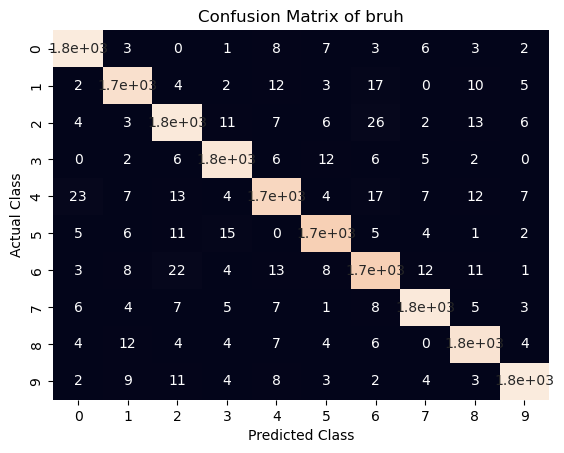

In [302]:
fig, ax = plt.subplots()

plot_confusion_matrix(CM_cnn, ax, 'bruh')